# Driver Drowsiness Detection System

Studies indicate that fatigue-related crashes account for about 20% of road accidents and even more on roads with no driving hour regulations. Driver detection systems, particularly those focusing on drowsiness detection, aim to address that alarming rate by monitoring drivers for signs of drowsiness and issuing timely alerts to prevent potential crashes.

For our final project, we chose to develop a DDS that will utilize a convolutional neural network (CNN) trained on the [UTA Dataset](https://www.kaggle.com/datasets/rishab260/uta-reallife-drowsiness-dataset) (comprised of drowsy/neutral/alert driver images). The model's prediction will then provide alerts based on the detected level of fatigue in real time through a webcam notification. 

*Dataset needs to be downloaded and stored in the root directory - frames from the UTA dataset have been extracted by us separately, through [code available on Kaggle](https://www.kaggle.com/code/jmash12/film-to-frames)*

### Requirements 
- TensorFlow: Developed by the Google Brain team for machine learning and artificial intelligence, Tensorflow has a allows for training and inference of deep neural networks.

- Keras: Provides a Python interface for artificial neural networks (inbuilt python library).

- Numpy: Used for scientific computing in Python. Provides support for arrays, matrices, and various mathematical functions to operate on them. 

- OpenCV: Machine learning and compiter vision library; contains >2500 algorhitms optimized for various CV tasks; allows for webcam access.

- Scikit-learn: Data mining, data analysis. In this project, used for splitting datasets. 

- Pandas: Data manipulation and analysis library. Used to create dataframes associating frames with their labels.

- Kagglehub: For downloading Kaggle datasets 

- Visualkeras: For network visualization


In [12]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import cv2
import os
import kagglehub
import visualkeras
from tensorflow.keras import regularizers


In [13]:
# PRESETS 
# Current working directory 
working_dir = '/kaggle/input/drowsy-driver-imagesonly/Drowsey Driver Images'
# UTA DD Dataset directory (frames = participant_02_vid...)
uta_dir = working_dir + '/frames' 
# Image size for VGG16
IMG_SIZE = 224 

### Appending Labels for the UTA Dataset 
Frames captured are associated with **not drowsy, neutral, and drowsy classes**, based on the 'vid' label within the parsed filename. They're later saved to a pandas dataframe for training, validating, and testing.

In [14]:
def parse_filename(filename):
    parts = filename.split('_')
    for i, part in enumerate(parts):
        if part.lower() == 'vid':
            label = int(parts[i + 1])
            if label == 0:
                return 'not_drowsy'
            elif label == 5:
                return 'neutral'
            elif label == 10:
                return 'drowsy'
            else:
                return None
    return None

In [15]:
# Function to process the images. 
def create_dataframe(image_dir):
    data = []
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            if file.endswith('.jpg'):
                label = parse_filename(file)
                if label:
                    data.append((os.path.join(root, file), label))
    return pd.DataFrame(data, columns=['filepath', 'label'])

df_drowsiness = create_dataframe(working_dir)

# Sanity check
df_drowsiness.sample(5)

,filepath,label
263,/kaggle/input/drowsy-driver-imagesonly/Drowsey...,neutral
2765,/kaggle/input/drowsy-driver-imagesonly/Drowsey...,neutral
2629,/kaggle/input/drowsy-driver-imagesonly/Drowsey...,neutral
5115,/kaggle/input/drowsy-driver-imagesonly/Drowsey...,neutral
1642,/kaggle/input/drowsy-driver-imagesonly/Drowsey...,drowsy


### Preparing and Augmenting the Model
The dataset is split into training, validation, and testing sets. The frames are then rescaled, as well as augmented for the training dataset to increase the variety of data.

In [16]:
# Initialization of the train, validation, and test datasets extracted from the UTA RealLife Drowsiness Dataset. 
train_val_df, test_df = train_test_split(df_drowsiness, test_size=0.2, stratify=df_drowsiness['label'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['label'], random_state=42)

train_datagen = ImageDataGenerator(rescale=0.2)
val_datagen = ImageDataGenerator(rescale=0.2)
test_datagen = ImageDataGenerator(rescale=0.2)

# Artificially increases size of the training dataset; ensures a wider range of imgs. 
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

Found 3450 validated image filenames belonging to 3 classes.
Found 1150 validated image filenames belonging to 3 classes.
Found 1150 validated image filenames belonging to 3 classes.


### Model Definition, Compilation, and Training
The model architecture is defined using a pre-trained (on ImageNet) VGG16 base model. The top layers are excluded and the input shape is specified to match the dimensions of our input data. Custom layers are then added for the 3-class classification. To prevent the weights of the pre-trained VGG16 base model from being updated during training, we freeze all the layers of the base model, after which the model is compiled, and trained using the training and validation datasets. 

In [17]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax', kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01))(x)  # 3 classes: 0 - not_drowsy, 5 - drowsy, 10 - neutral

model = Model(inputs=base_model.input, outputs=predictions)

# The base is freezed
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# ! Actual training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=5
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 1291s 24s/step - accuracy: 0.7834 - loss: 2.0986 - val_accuracy: 0.9467 - val_loss: 0.5415
Epoch 2/5
 1/53 ━━━━━━━━━━━━━━━━━━━━ 15:19 18s/step - accuracy: 0.9219 - loss: 0.5736

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 331ms/step - accuracy: 0.9219 - loss: 0.5736 - val_accuracy: 0.9355 - val_loss: 0.5211
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 1291s 24s/step - accuracy: 0.9423 - loss: 0.5234 - val_accuracy: 0.9660 - val_loss: 0.4550
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 330ms/step - accuracy: 0.9219 - loss: 0.5360 - val_accuracy: 0.9677 - val_loss: 0.4196
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 1291s 24s/step - accuracy: 0.9620 - loss: 0.4453 - val_accuracy: 0.9733 - val_loss: 0.3958


In [23]:
model.save_weights('drowsiness_weights.weights.h5')

### Network Architecture 

/opt/conda/lib/python3.10/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


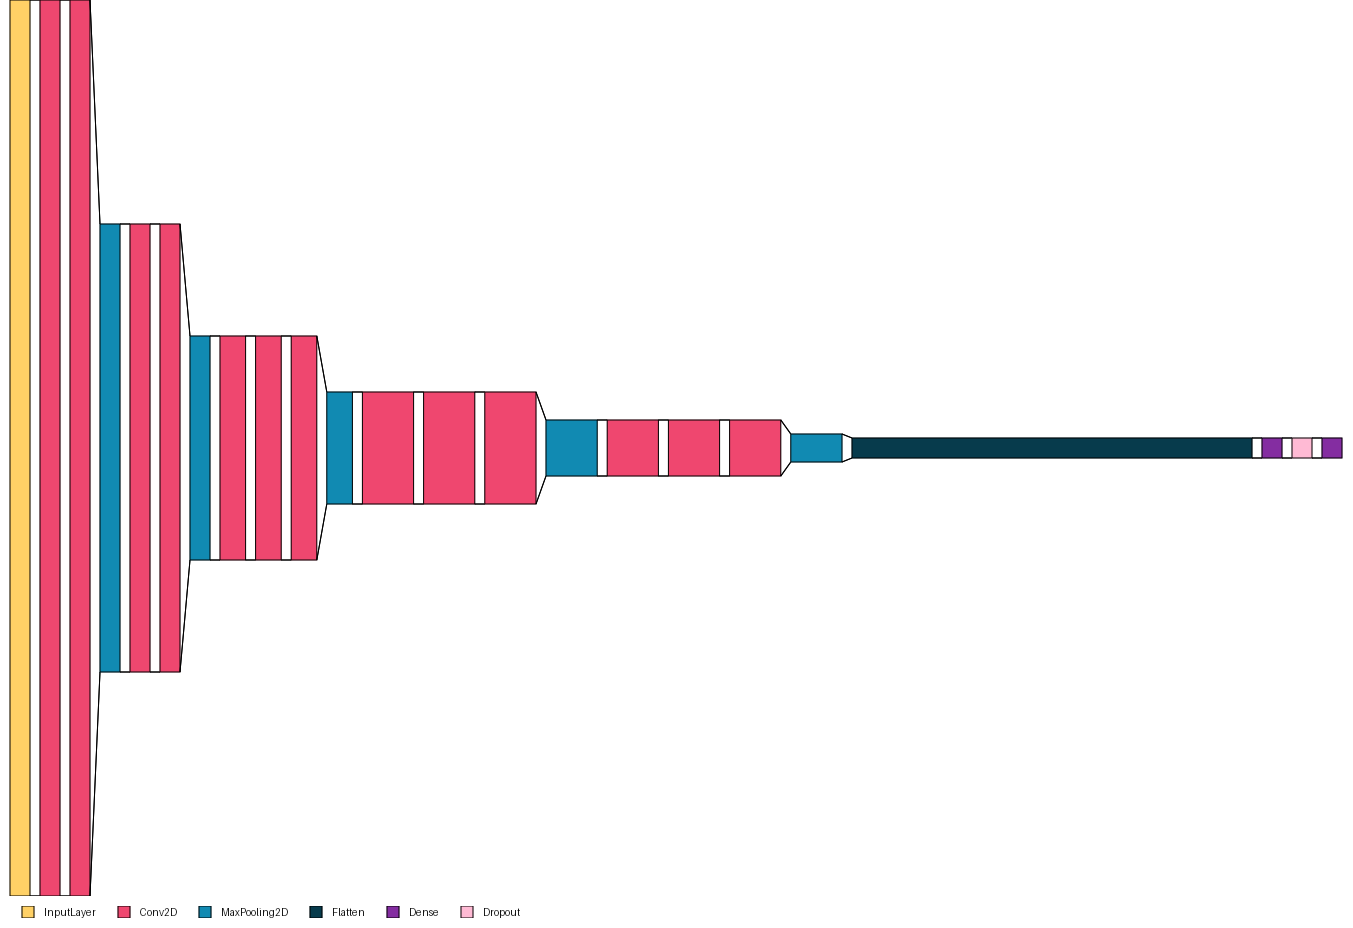

In [24]:
plot_model(model, to_file='model_drowsiness.png', show_shapes=True, show_layer_names=True)
visualkeras.layered_view(model, legend=True, draw_volume=False)

### Performance evaluation
With the accuracy surprisingly high, we've checked the appropriateness of labels (correct - the dataset is balanced; same amount of drowsy, neutral, and not drowsy images), and for potential data leakage issues (none - we've verified the integrity of train-test splits, all of the dataframe's feature column cells are unique).

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 333s 18s/step - accuracy: 0.9808 - loss: 0.3818
Test loss: 0.38033148646354675
Test accuracy: 0.9800000190734863


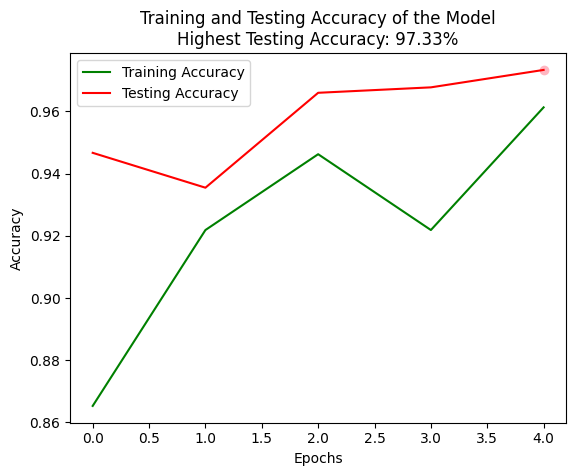

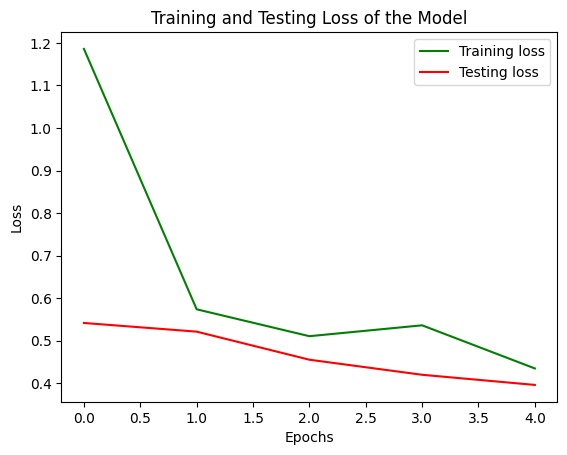

In [25]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

# Accuracy and loss plots
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

# Highest testing accuracy and its index
max_val_acc = max(val_accuracy)
min_val_acc = min(val_accuracy)
max_val_acc_index = val_accuracy.index(max_val_acc)
max_accuracy = max(accuracy)
min_loss = min(loss)
min_val_loss = min(val_loss)
plt.plot(max_val_acc_index, max_val_acc, marker='o', color='lightpink')

# Training and testing accuracy over epochs
plt.plot(epochs, accuracy, "g", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "r", label="Testing Accuracy")
plt.legend()
plt.title("Training and Testing Accuracy of the Model\nHighest Testing Accuracy: {:.2f}%".format(max_val_acc*100))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

# Plotting loss over epochs
plt.plot(epochs, loss, "g", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Testing loss")
plt.legend()
plt.title("Training and Testing Loss of the Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Confusion Matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 10s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step


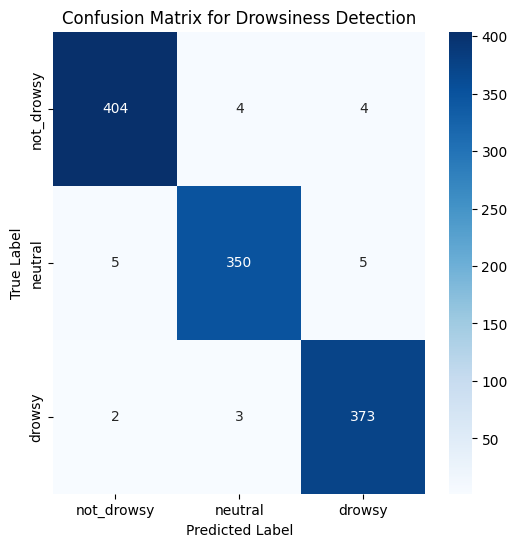

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predicting on the test set
test_preds = []
test_labels = []

# Iterating through the test data
for i in range(len(test_generator)):
    images, labels = test_generator[i]
    preds = model.predict(images)
    test_preds.extend(np.argmax(preds, axis=1))
    test_labels.extend(np.argmax(labels, axis=1))  # Get the true classes

# Convert to numpy arrays for ease of use
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)

# Generate the confusion matrix
cm = confusion_matrix(test_labels, test_preds)
labels = ['not_drowsy', 'neutral', 'drowsy']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for Drowsiness Detection')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Real-Time Driver Drowsiness Detection 
Using the model defined above, we'll now implement a real-time DDS based on a webcam. The code captures live video frames using OpenCV, processes them to match the input requirements of the trained model, and performs predictions to determine drowsy vs alert state. The model's predictions are overlaid onto the video feed in real time, displaying the driver's status and confidence scores. 

*The system is interactive, allowing the user to view the annotated video feed and terminate the program by pressing the 'q' key.*

In [27]:
# Rebuilding both models to omit steps above, with the weights already generated
# -------------------------- Drowsiness Model --------------------------
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax', kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01))(x)  # 3 classes: 0 - not_drowsy, 5 - drowsy, 10 - neutral

model = Model(inputs=base_model.input, outputs=predictions)
# The base is freezed
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_drowsiness_path = "drowsiness_weights.weights.h5"
model.load_weights(model_drowsiness_path)

In [30]:
# Configuration for alert system
consecutive_drowsy_frames = 3  # Num of consecutive "drowsy" frames to trigger alert
drowsy_counter = 0
map_labels = {0: 'not_drowsy', 1: 'neutral', 2: 'drowsy'}

# Defining the preprocessing function to match the model's input requirements. Returns a single adjusted frame. 
def preprocess_frame(frame):
  # Normalize 
  img = frame / 255
  # Resize to match the size used during training
  resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
  # Reshape the image to match the input shape 
  return resized.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# Starting the camera; 0 - default camera
cap = cv2.VideoCapture(0) 

print("Press 'q' to quit the webcam stream.")
while cap.isOpened():
  ret, frame = cap.read()  # Reading frame-by-frame
  if not ret:
    print("Failed to capture frame. Exiting...")
    break
  
  processed_frame = preprocess_frame(frame)

  # Making a prediction
  prediction_drowsy = model.predict(processed_frame)
  drowsy = np.argmax(prediction_drowsy) 
  drowsy_label = map_labels[drowsy]
  print(prediction_drowsy)
  print(drowsy_label)

  # Combine predictions. Final status will be drowsy if 30 cons frames are drowsy (/closed/yawn)
  if drowsy_label == 'drowsy':  # must be drowsy and (closed eyes or yawning)
    drowsy_counter += 1
  else: 
    drowsy_counter = 0

  # Checking if alert conditions are met
  if drowsy_counter >= consecutive_drowsy_frames:
    status = "Drowsiness Detected"
    color = (0, 0, 255)  
  else :
    status = "No Drowsiness Detected"
    color = (0, 255, 0)

  # Annotating the frame
  cv2.putText(frame, f"Status: {status}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
  cv2.putText(frame, f"Prediction confidence: {prediction_drowsy[0][drowsy]*100:.2f}", (10, 70),
                cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
  # Displaying the frame with annotations
  cv2.imshow("Drowsy Driver Detection", frame)

  # Breaking the loop once 'q' is pressed
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break

cap.release()

Press 'q' to quit the webcam stream.


[ WARN:0@5025.129] global cap_v4l.cpp:999 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@5025.129] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range
